In [2]:
!pip install optuna

     ---------------------------------------- 57.7/57.7 kB 3.0 MB/s eta 0:00:00
   --------------------------------------- 362.8/362.8 kB 11.4 MB/s eta 0:00:00
   --------------------------------------- 226.8/226.8 kB 13.5 MB/s eta 0:00:00
   ---------------------------------------- 2.1/2.1 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
   ---------------------------------------- 298.9/298.9 kB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 78.7/78.7 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0


In [3]:
# Essential libraries for data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities for model validation and evaluation
from sklearn.model_selection import train_test_split, cross_val_score

# Preprocessing and pipeline setup
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model and evaluation metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter optimization
import optuna

In [4]:
data= pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\sleeptime_prediction_dataset.csv')

In [5]:
data.head()

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.12,0.52,3.29,7.89,216.08,0.75,3.45
1,2.85,0.49,4.22,5.03,206.18,0.67,4.88
2,2.20,1.81,4.04,9.23,28.73,0.35,3.61
3,1.80,0.50,1.62,7.68,276.77,1.21,4.94
4,0.47,0.54,1.60,4.94,170.54,0.95,5.50


In [6]:
data.shape

(2000, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WorkoutTime     2000 non-null   float64
 1   ReadingTime     2000 non-null   float64
 2   PhoneTime       2000 non-null   float64
 3   WorkHours       2000 non-null   float64
 4   CaffeineIntake  2000 non-null   float64
 5   RelaxationTime  2000 non-null   float64
 6   SleepTime       2000 non-null   float64
dtypes: float64(7)
memory usage: 109.5 KB


In [8]:
data.isna().sum()

WorkoutTime       0
ReadingTime       0
PhoneTime         0
WorkHours         0
CaffeineIntake    0
RelaxationTime    0
SleepTime         0
dtype: int64

In [9]:
data.duplicated().sum()

0

In [11]:
X= data.drop('SleepTime', axis=1)
y= data['SleepTime']

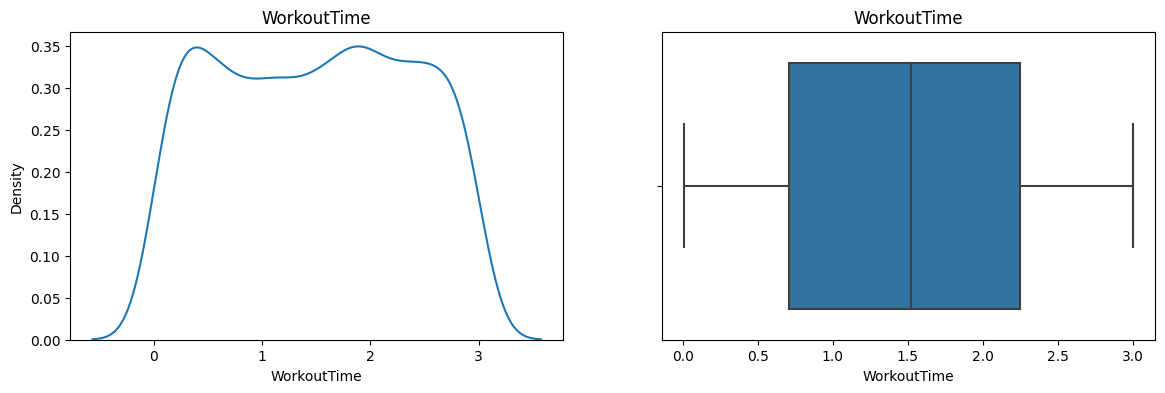

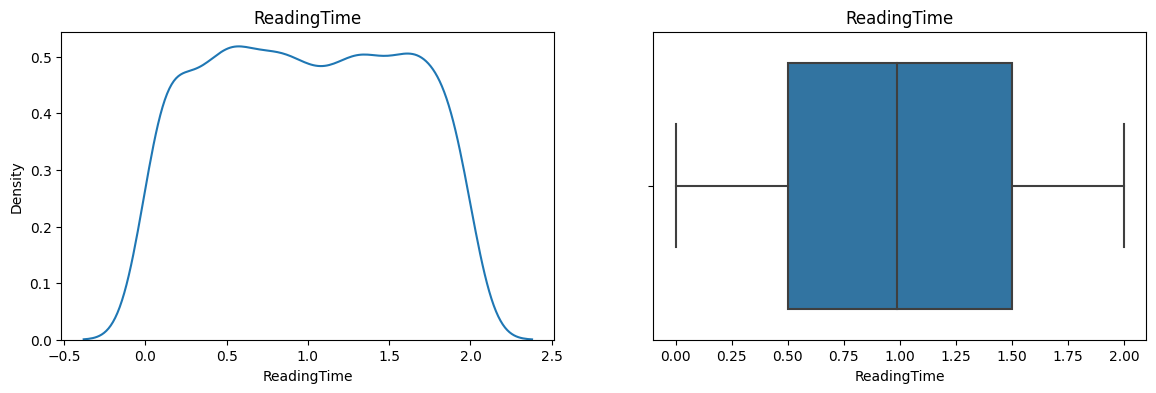

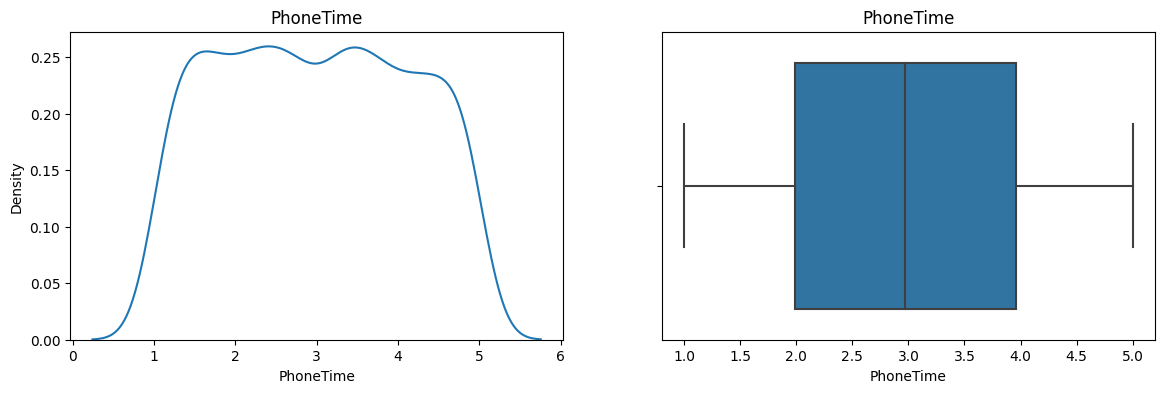

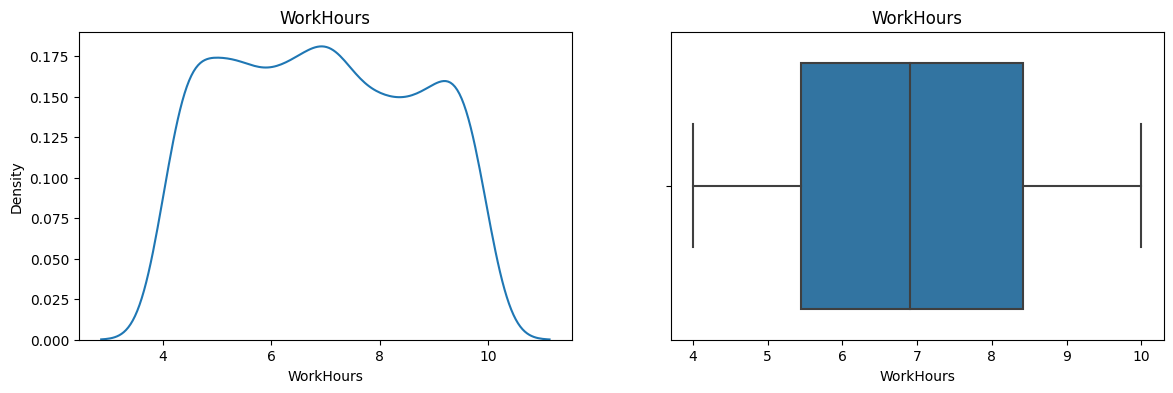

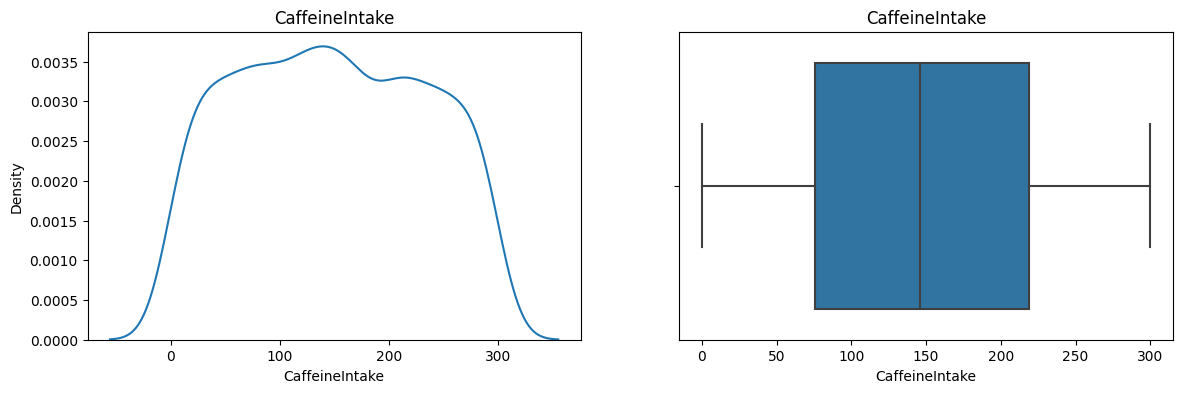

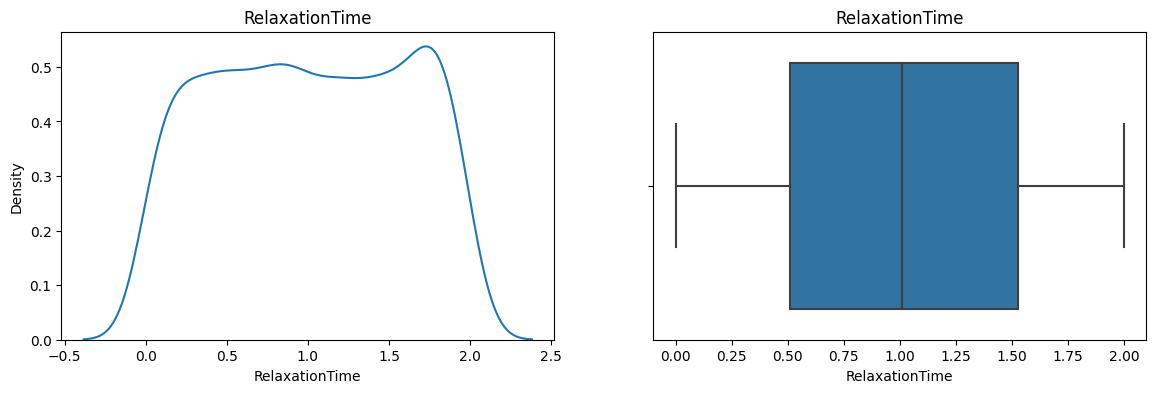

In [12]:
for col in X.columns:

    plt.figure(figsize=(14, 4))

    plt.subplot(121)
    sns.kdeplot(data=data, x=col)
    plt.title(col)

    plt.subplot(122)
    sns.boxplot(data=data, x=col)
    plt.title(col)

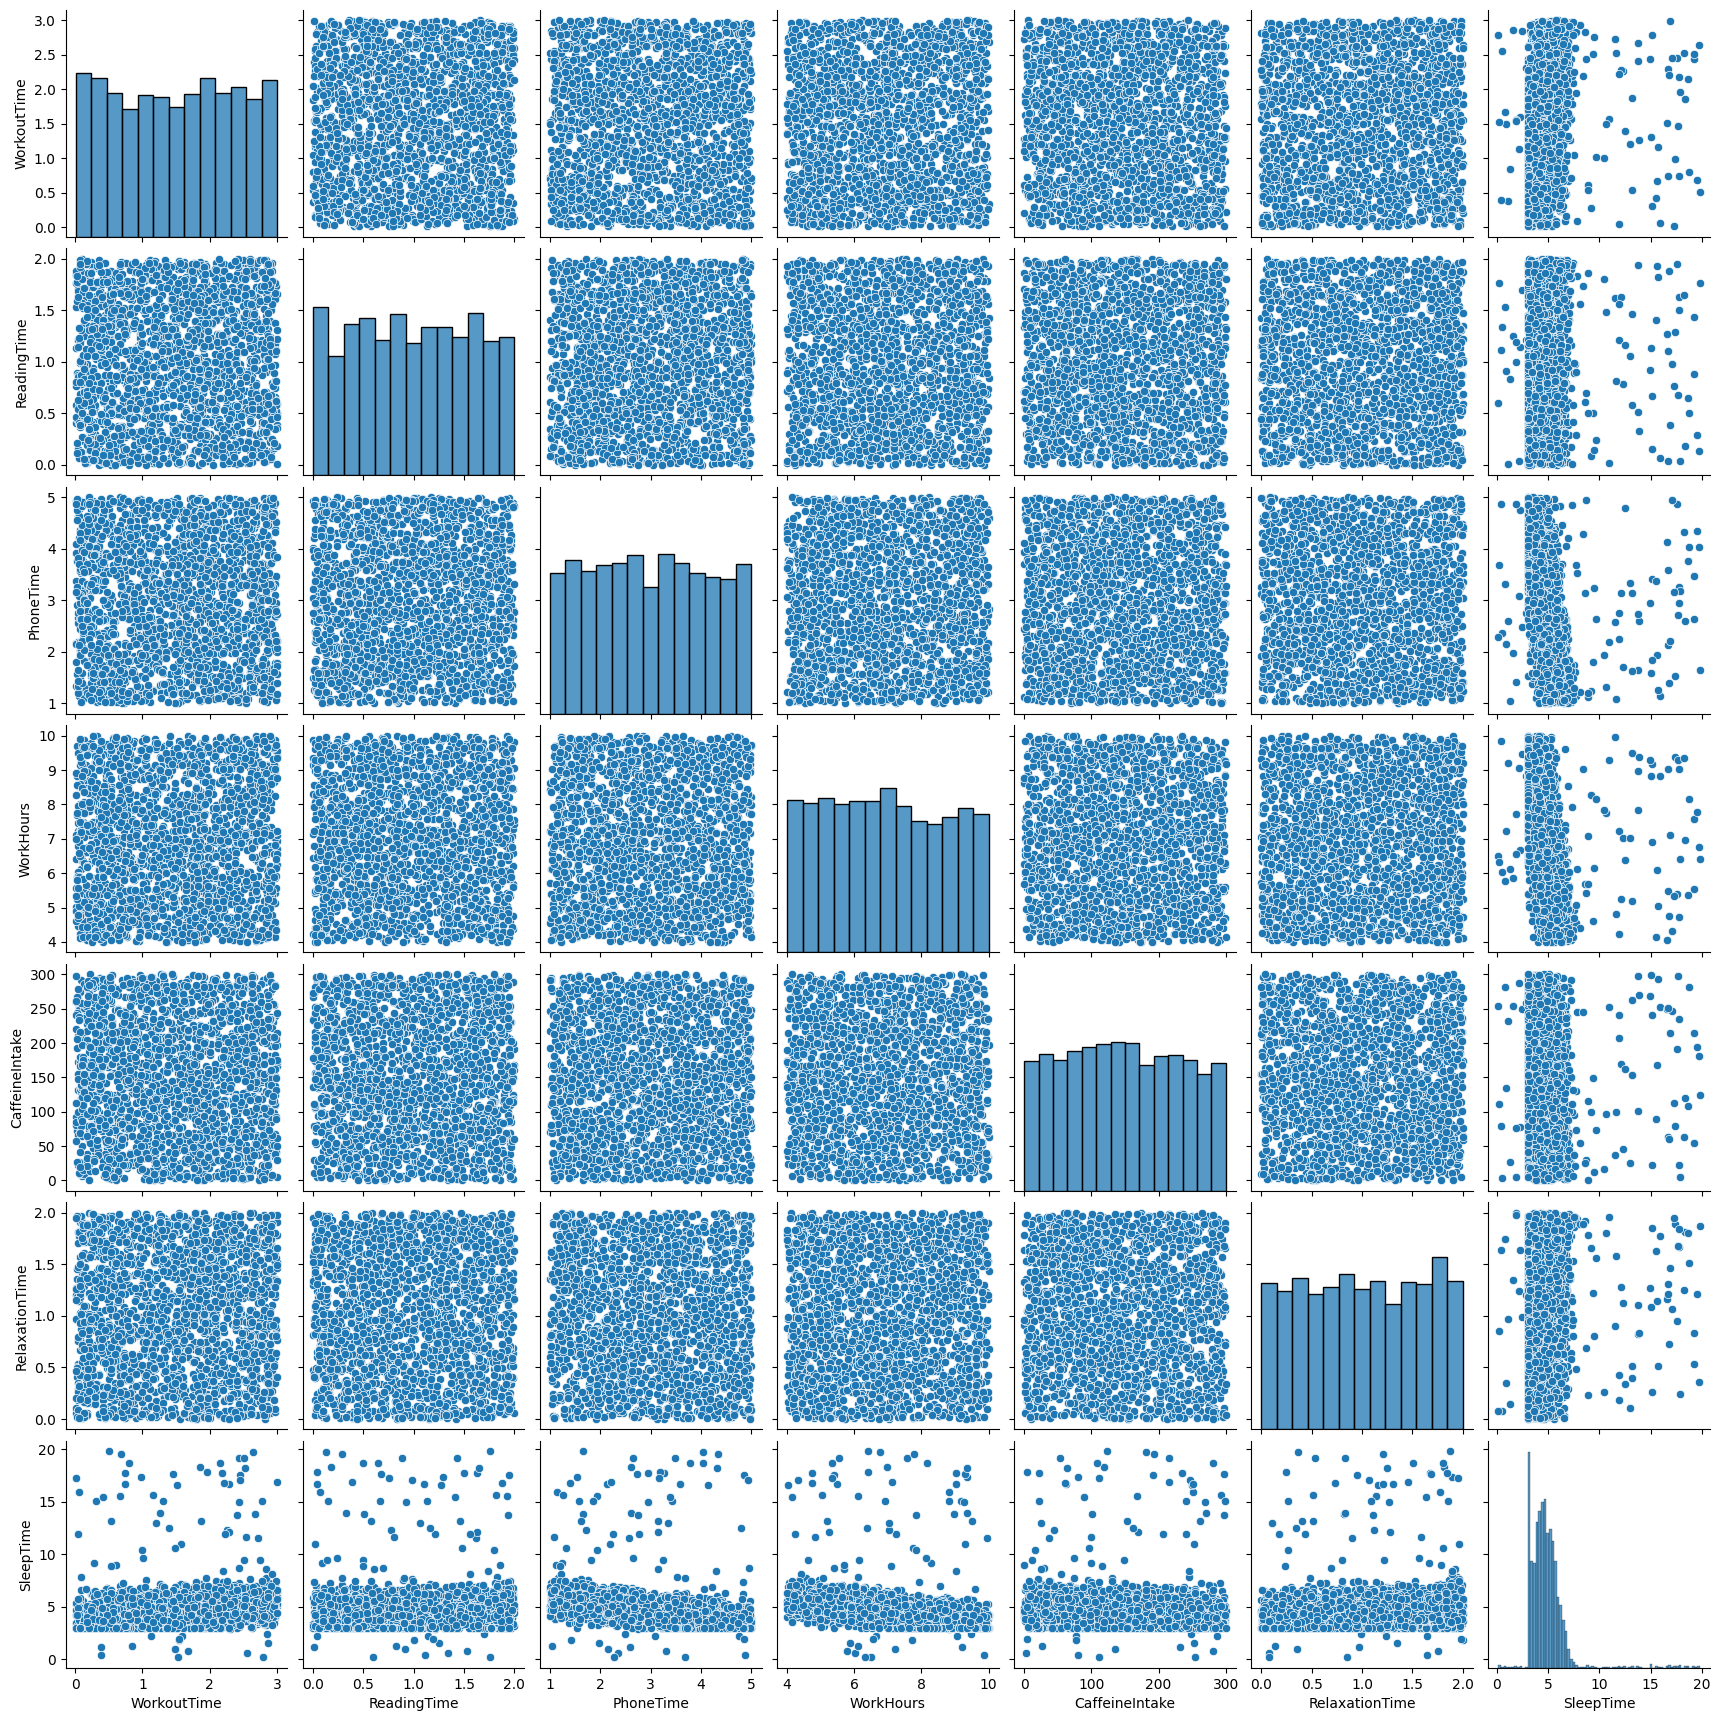

In [13]:
sns.pairplot(data=data)

<AxesSubplot:>

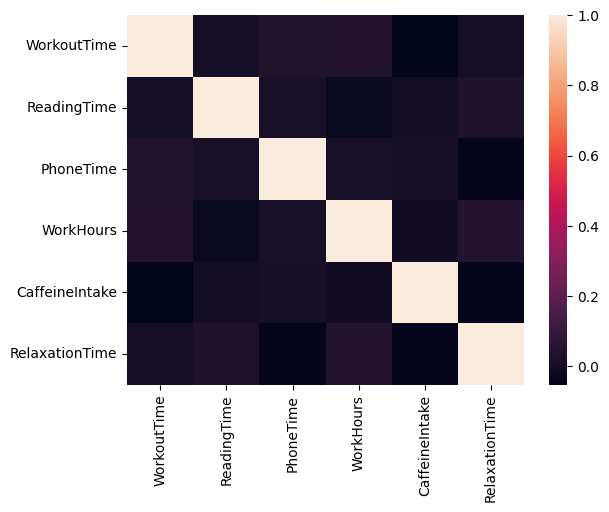

In [14]:
c= X.corr()
sns.heatmap(c)

In [15]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

In [16]:
# Preprocessing pipeline using PowerTransformer to scale the features
preprocessor= ColumnTransformer([
    ('Power_Transformer', PowerTransformer(), X.columns)
])

In [17]:
# Initialize the Random Forest model
model = RandomForestRegressor()

# Create a pipeline with preprocessing and model steps
pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model) 
])

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Power_Transformer',
                                                  PowerTransformer(),
                                                  Index(['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours',
       'CaffeineIntake', 'RelaxationTime'],
      dtype='object'))])),
                ('model', RandomForestRegressor())])

In [18]:
y_preds= pipe.predict(X_test)

r2_sc= r2_score(y_test, y_preds)
print(r2_sc)

0.15416524127152598


In [19]:
def random_forest_objective(trial):

    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    
    criterion = trial.suggest_categorical('criterion', ["squared_error", "absolute_error", "friedman_mse", "poisson"])

    
    
    # Initialize the Random Forest model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion= criterion,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_samples= max_samples, 
        random_state=42
    )

    pipe= Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    cv_score= cross_val_score(estimator=pipe, X=X, y=y, cv=5, scoring='r2').mean()

    return cv_score

In [20]:
random_forest_study= optuna.create_study(direction='maximize')
random_forest_study.optimize(random_forest_objective, n_trials=100)

[I 2024-12-29 23:01:23,099] A new study created in memory with name: no-name-a188eeff-8386-4b56-a7cf-e64b61c45a6c
[I 2024-12-29 23:01:25,139] Trial 0 finished with value: 0.1537357777690314 and parameters: {'n_estimators': 73, 'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9984194586104993, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.1537357777690314.
[I 2024-12-29 23:01:27,301] Trial 1 finished with value: 0.10418621844200773 and parameters: {'n_estimators': 123, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_samples': 0.5807680240337795, 'criterion': 'poisson'}. Best is trial 0 with value: 0.1537357777690314.
[I 2024-12-29 23:01:29,905] Trial 2 finished with value: 0.20872071411014975 and parameters: {'n_estimators': 154, 'max_depth': 6, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_samples': 0.7166565257184987, 'criterion': 'squared_error

[I 2024-12-29 23:02:38,773] Trial 26 finished with value: 0.24109703364749743 and parameters: {'n_estimators': 107, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_samples': 0.5564918092798605, 'criterion': 'friedman_mse'}. Best is trial 19 with value: 0.24154516281905228.
[I 2024-12-29 23:02:39,945] Trial 27 finished with value: 0.23845914723759223 and parameters: {'n_estimators': 103, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_samples': 0.6843680541360843, 'criterion': 'friedman_mse'}. Best is trial 19 with value: 0.24154516281905228.
[I 2024-12-29 23:02:40,976] Trial 28 finished with value: 0.2419987451174955 and parameters: {'n_estimators': 101, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_samples': 0.5756597486209325, 'criterion': 'friedman_mse'}. Best is trial 28 with value: 0.2419987451174955.
[I 2024-12-29 23:02:45,102] Trial 29 finish

[I 2024-12-29 23:03:22,726] Trial 52 finished with value: 0.2410560370980291 and parameters: {'n_estimators': 66, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_samples': 0.9150904851139231, 'criterion': 'squared_error'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:03:23,405] Trial 53 finished with value: 0.23900659299522928 and parameters: {'n_estimators': 55, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_samples': 0.8300329846918336, 'criterion': 'squared_error'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:03:24,430] Trial 54 finished with value: 0.2401457919803736 and parameters: {'n_estimators': 99, 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_samples': 0.6272526949367856, 'criterion': 'squared_error'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:03:25,291] Trial 55 finis

[I 2024-12-29 23:04:24,090] Trial 78 finished with value: 0.2415034379609325 and parameters: {'n_estimators': 93, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_samples': 0.5460219606272328, 'criterion': 'friedman_mse'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:04:25,044] Trial 79 finished with value: 0.23999583819424056 and parameters: {'n_estimators': 93, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_samples': 0.5495879639262434, 'criterion': 'friedman_mse'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:04:26,070] Trial 80 finished with value: 0.23960979464804702 and parameters: {'n_estimators': 106, 'max_depth': 16, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_samples': 0.5191641590775088, 'criterion': 'friedman_mse'}. Best is trial 37 with value: 0.24393585984615992.
[I 2024-12-29 23:04:27,878] Trial 81 finished 

In [21]:
random_forest_study.best_value, random_forest_study.best_params

(0.24393585984615992,
 {'n_estimators': 86,
  'max_depth': 14,
  'max_features': 'sqrt',
  'min_samples_split': 11,
  'min_samples_leaf': 7,
  'max_samples': 0.6018415193373174,
  'criterion': 'squared_error'})

In [22]:
# Initialize the RandomForestRegressor with the best hyperparameters from Optuna
best_model = RandomForestRegressor(
    n_estimators= random_forest_study.best_params['n_estimators'],
    criterion= random_forest_study.best_params['criterion'],
    max_depth= random_forest_study.best_params['max_depth'],
    max_features= random_forest_study.best_params['max_features'],
    min_samples_split= random_forest_study.best_params['min_samples_split'],
    min_samples_leaf= random_forest_study.best_params['min_samples_leaf'],
    max_samples= random_forest_study.best_params['max_samples'], 
    random_state=42
)

# Create a pipeline with preprocessing and the best model
best_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', best_model) 
])

# Fit the pipeline with the training data
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Power_Transformer',
                                                  PowerTransformer(),
                                                  Index(['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours',
       'CaffeineIntake', 'RelaxationTime'],
      dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=14, max_features='sqrt',
                                       max_samples=0.6018415193373174,
                                       min_samples_leaf=7, min_samples_split=11,
                                       n_estimators=86, random_state=42))])

In [23]:
y_preds= best_pipe.predict(X_test)

In [24]:
mean_absolute_error(y_test, y_preds)

0.5894080321831852

In [25]:
mean_squared_error(y_test, y_preds)

2.789221717467168

In [26]:
np.sqrt(mean_squared_error(y_test, y_preds))

1.6700963198172636

In [27]:
r2_score(y_test, y_preds)

0.2591929740745097

In [28]:
importances= best_pipe.named_steps['model'].feature_importances_

preprocessor_features= best_pipe.named_steps['preprocessor'].get_feature_names_out()

features= np.array([s.split('__')[1] for s in preprocessor_features])

In [29]:
importances

array([0.15479355, 0.07434831, 0.28626754, 0.28630459, 0.09124732,
       0.10703869])

In [30]:
preprocessor_features

array(['Power_Transformer__WorkoutTime', 'Power_Transformer__ReadingTime',
       'Power_Transformer__PhoneTime', 'Power_Transformer__WorkHours',
       'Power_Transformer__CaffeineIntake',
       'Power_Transformer__RelaxationTime'], dtype=object)

In [31]:
features

array(['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours',
       'CaffeineIntake', 'RelaxationTime'], dtype='<U14')

In [32]:
df_importances= pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

In [33]:
df_importances

,Feature,Importance
0,WorkoutTime,0.154794
1,ReadingTime,0.074348
2,PhoneTime,0.286268
3,WorkHours,0.286305
4,CaffeineIntake,0.091247
5,RelaxationTime,0.107039


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

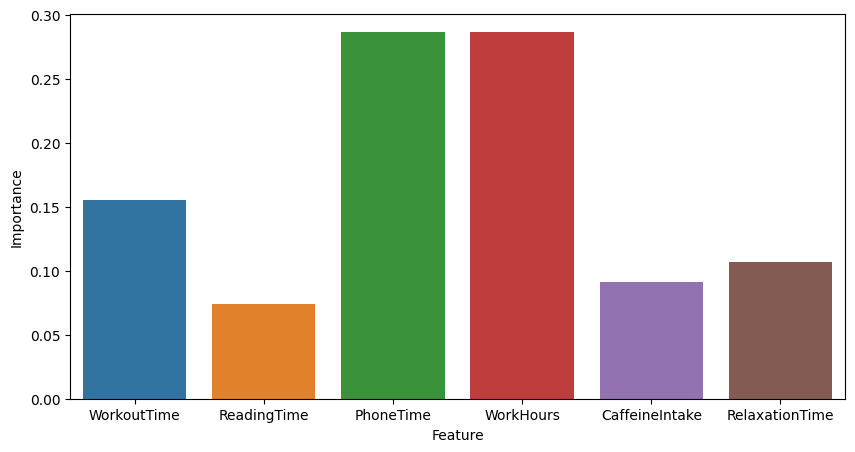

In [34]:
plt.figure(figsize=(10, 5))

sns.barplot(data= df_importances, x= 'Feature', y= 'Importance' )